In [1]:
# Brent

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import STL

import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import r2_score

import tensorflow as tf

/home/manero/DL/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2023-03-05 00:28:47.043148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-05 00:28:47.043173: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Load and Cleanse csv into Dataframe

In [3]:
df = pd.read_csv('./brent_price.csv')
# date is not date transform it into datetime
df['date'] = pd.to_datetime(df['DATE'])
df.dtypes
len_dataframe = len(df)
print(len_dataframe)
df.columns

4587


Index(['DATE', 'DCOILBRENTEU', 'date'], dtype='object')

In [4]:
df.describe()

,DCOILBRENTEU
count,4587.000000
mean,75.458886
std,25.245634
min,9.120000
25%,56.095000
50%,70.550000
75%,98.640000
max,143.950000


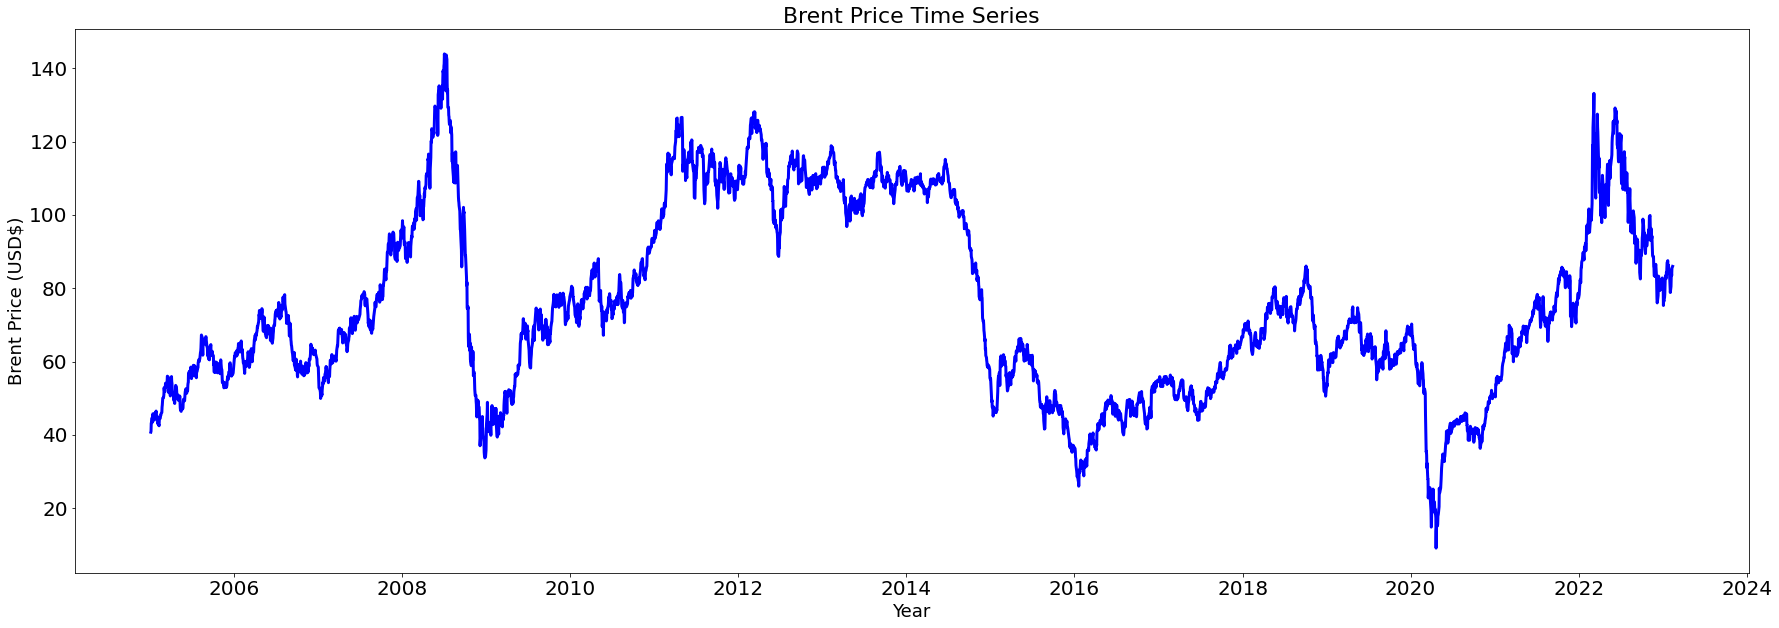

In [5]:
# Dataset Visualization

fig, ax = plt.subplots(figsize=(30,10))


ax.plot(df['date'],df['DCOILBRENTEU'],color='blue',linewidth=3.0)
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100.)
plt.title("Brent Price Time Series", size=22)
plt.ylabel("Brent Price (USD$)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig("figure_image.jpg")
plt.show()

#### Time Series Decomposition to analyze Seasonality and Trend

/tmp/ipykernel_43378/1289662868.py:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dfa = dfa.fillna(df.mean())
/tmp/ipykernel_43378/1289662868.py:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfa = dfa.fillna(df.mean())


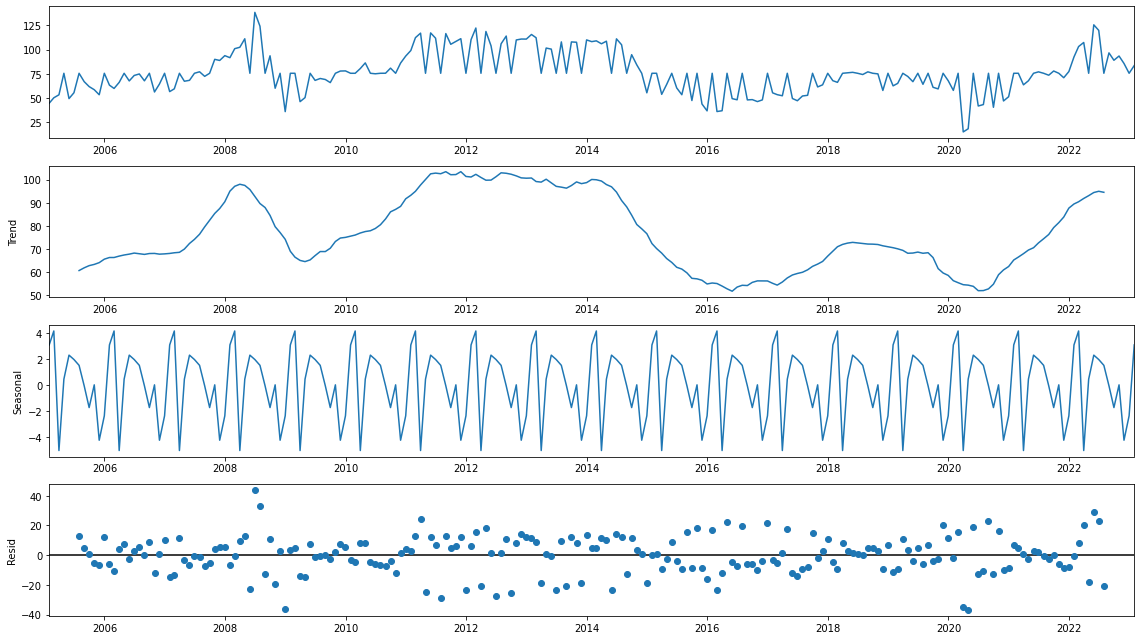

In [6]:
plt.rcParams["figure.figsize"] = [16,9]
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

dfa = df
dfa.reset_index(drop=True,inplace=True)
dfa = dfa.set_index('date').asfreq('m')
dfa = dfa.fillna(df.mean())
#s = sm.tsa.seasonal(dfa['DCOILBRENTEU'])
dfa = dfa.drop(columns=['DATE'])

decomposition = seasonal_decompose(dfa)
decomposition.plot()
plt.show()

In [7]:
# Stationarity test
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
check_stationarity(dfa['DCOILBRENTEU'])

ADF Statistic: -2.725283
p-value: 0.069764
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Non-stationary


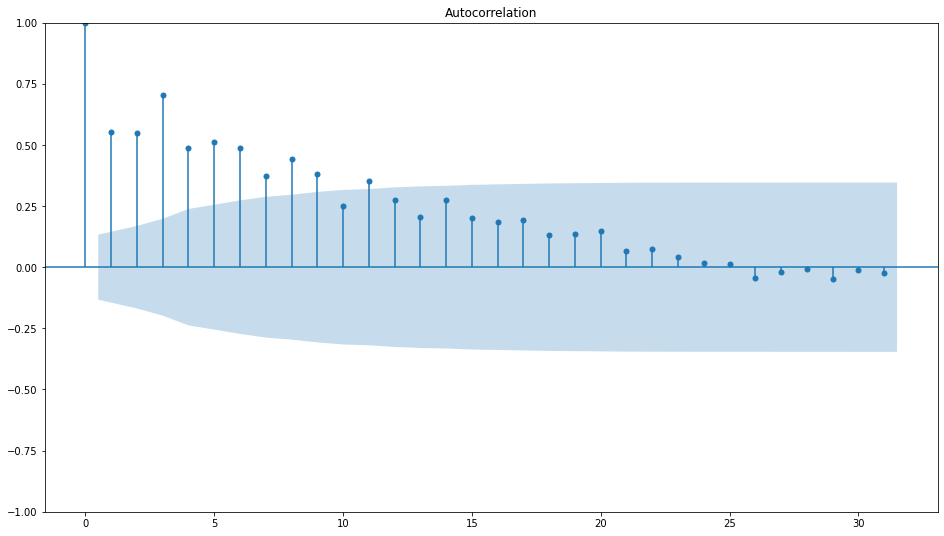

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dfa, lags = 31) 
plt.show()

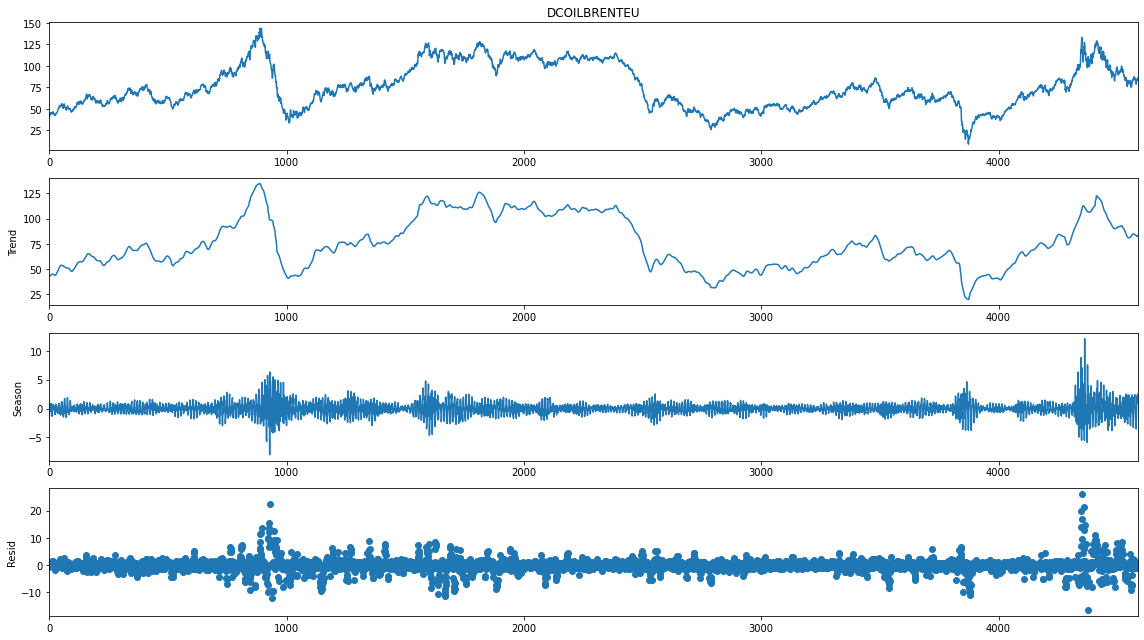

In [9]:
plt.rcParams["figure.figsize"] = [16,9]
stl = STL(df['DCOILBRENTEU'], period=12, robust=True)
result = stl.fit()
result.plot() 
plt.show()

In [10]:
# Time series is clearly without seasonality and trend
# We transform the prediction into a supervised learning approach
# <steps> - <prediction>
# How many steps can perform a horizon prediction?
ahead = 90     # we will perform at 90 days
lag = 50      # we use 10 steps as an example
length = len(df)

print('Number of steps (shape)', df.shape)
# we create a numpy array with all the steps
prices = df[["DCOILBRENTEU"]].to_numpy()

Number of steps (shape) (4587, 3)


In [11]:
s = prices
lvect = []

trainsize = len(s)
lvect = []
lvect2 = []
for i in range(lag, trainsize-lag-ahead):
   lvect.append(s[i:i+lag])
   lvect2.append(s[i+ahead+lag])   
X = np.stack(lvect, axis=1)
y = np.stack(lvect2, axis=1)
y = np.swapaxes(y, 1,0)
X = np.swapaxes(X, 0, 1)
X = np.squeeze(X)
y = np.squeeze(y)

In [12]:
# Split Train and Test
len_series = len(X)
cut = int(len_series*0.8)
train_x = X[:cut,:]
test_x  = X[cut:len_series,:]

train_y = y[:cut]
test_y  = y[cut:len_series]

In [13]:
print("=========== SHAPE INPUT-OUTPUT MATRIXES =====================")
print("shape x_training :", train_x.shape, " y_training: : ", train_y.shape)
print("shape x_test     : ", test_x.shape, " y_test      : ", test_y.shape)
print("=============================================================")

=========== SHAPE INPUT-OUTPUT MATRIXES =====================
shape x_training : (3517, 50)  y_training: :  (3517,)
shape x_test     :  (880, 50)  y_test      :  (880,)


In [14]:
XGB = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.11, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=1, n_estimators=100,
       n_jobs=1, nthread=None, random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

XGB.fit(train_x, train_y)
y_hat = XGB.predict(test_x)

print('R2 Value:',   r2_score(test_y, y_hat))
print('MAPE Value:', mean_absolute_percentage_error(test_y, y_hat))

R2 Value: 0.5461194227698927
MAPE Value: 0.26489568740453107


In [15]:
#Create a column for y_hat
pad = []
for i in range(lag-1):
   pad.append('0')    
pad_arr = np.array(pad)
prevision = np.concatenate((pad_arr, y_hat))
prevision = np.concatenate((prevision, pad_arr))
#np.concatenate((a, b), axis=0)
start_prediction = len_dataframe - len(prevision)
pad = []
for i in range(start_prediction):
   pad.append('0')    
pad_arr = np.array(pad)
prevision = np.concatenate((pad_arr, prevision))
df['prevision'] = prevision
df['prevision'] = df['prevision'].astype(float)

In [16]:
#Create a column for y_test
pad = []
for i in range(lag-1):
   pad.append('0')    
pad_arr = np.array(pad)
zz = np.concatenate((pad_arr, test_y))
zz = np.concatenate((zz, pad_arr))
#np.concatenate((a, b), axis=0)
start_prediction = len_dataframe - len(zz)
pad = []
for i in range(start_prediction):
   pad.append('0')    
pad_arr = np.array(pad)
zz = np.concatenate((pad_arr, zz))
df['real'] = zz
df['real'] = df['real'].astype(float)

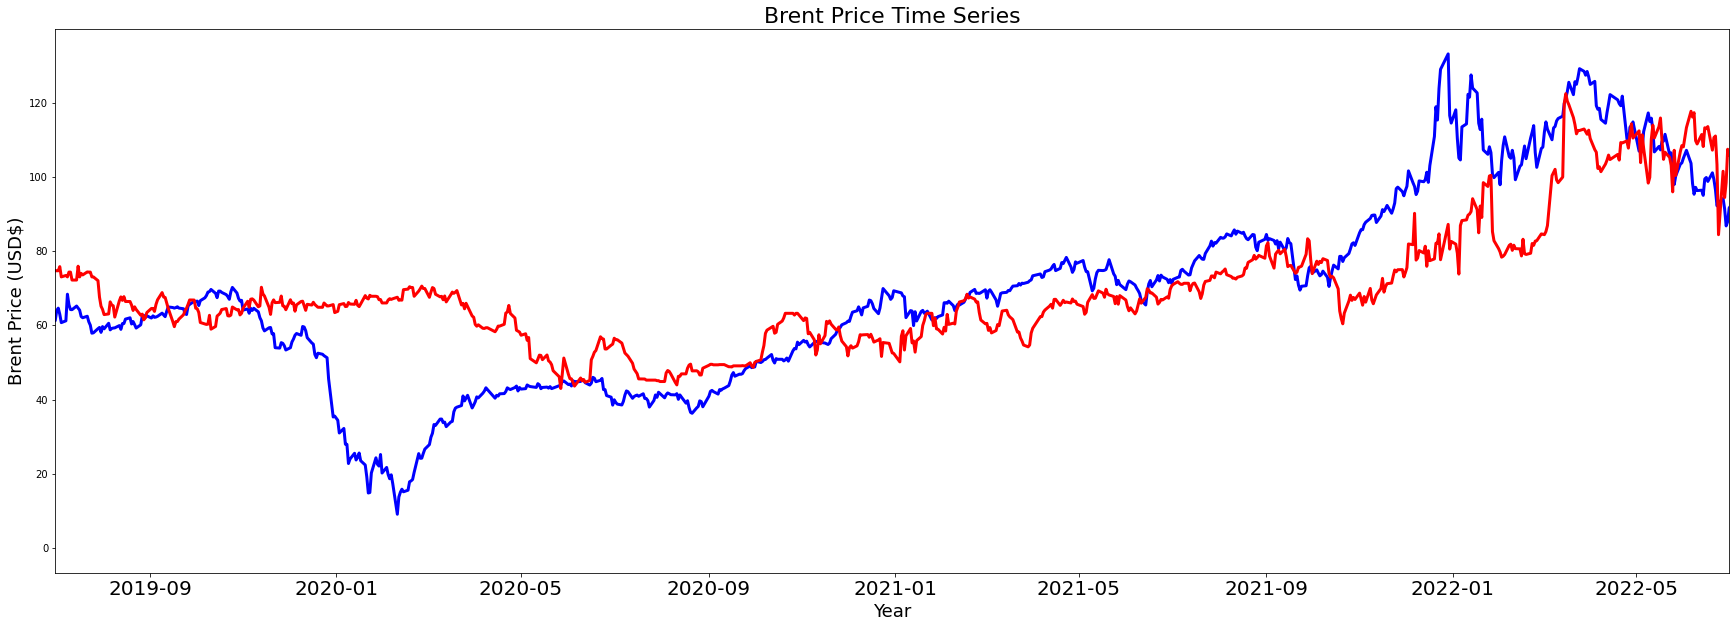

In [17]:
# Dataset Visualization

fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df['date'],df['real'],color='blue',linewidth=3.0)
ax.plot(df['date'],df['prevision'],color='red',linewidth=3.0)
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100.)
plt.title("Brent Price Time Series", size=22)
plt.ylabel("Brent Price (USD$)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.xlim('2019-07','2022-07')
#plt.yticks(fontsize=20)

#plt.savefig("figure_image.jpg")
plt.show()

In [18]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(max_depth=2, random_state=0)
RF.fit(train_x, train_y)
y_hat = RF.predict(test_x)

print('R2 Value:',   r2_score(test_y, y_hat))
print('MAPE Value:', mean_absolute_percentage_error(test_y, y_hat))

R2 Value: 0.5335373522725468
MAPE Value: 0.2817848032833022


In [19]:
from sklearn.svm import SVR
SVM = SVR(kernel = 'rbf')
SVM.fit(train_x, train_y)

SVM.fit(train_x, train_y)
y_hat = SVM.predict(test_x)

print('R2 Value:',   r2_score(test_y, y_hat))
print('MAPE Value:', mean_absolute_percentage_error(test_y, y_hat))

R2 Value: 0.512870354711769
MAPE Value: 0.2887703415279842


In [ ]:
#EOF